In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

 
import os
import random
import sklearn
from scipy.ndimage import imread
import skipthoughts
import nltk


# Load cifar-10 data


def load_input_images(path):
    working_dir = path
    file_list = []
    for root, dirs, files in os.walk(working_dir):
        for filename in files:
            if filename.endswith('.jpg'):
                file_list.append(root + "/" + filename) 
    images = []
    for myfile in file_list:
        image = imread(myfile)
        images.append(image)
    num_images = len(images)
    images=np.asarray(images)
    
    images=images.reshape(num_images,1,28,28)
    images=images.reshape(images.shape[0], 1, 28, 28).transpose(
        0, 2, 3, 1).astype("uint8")
       
    return images / 255.0
    
def load_input_sentences():
    nltk.download('popular')
    sentence_file = open('./dataset/input/sentences.txt','r')
    sentence = sentence_file.readline()
    
    sentences = []
    solutions = []
    
    while sentence != '':
        sentences.append(sentence)
        solution = sentence.split(' ')[-1]
        solutions.append(int(solution))
        sentence = sentence_file.readline()
    model = skipthoughts.load_model()
    encoder = skipthoughts.Encoder(model)

    sentences = encoder.encode(sentences)
        
    return sentences, solutions

def load_input(path):
    input_images = load_input_images(path)
    input_sentences, labels = load_input_sentences()
    
    inputs = list(zip(input_images, input_sentences, labels))
    random.shuffle(inputs)
    input_images, input_sentences, labels = zip(*inputs)
    
    return input_images, input_sentences, labels


train_path = './dataset/input/'
train_images, train_sentences, train_labels = load_input(train_path)
#test_samples = load_test_data() / 255.0

[nltk_data] Downloading collection u'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/madhvikannan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/madhvikannan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/madhvikannan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/madhvikannan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/madhvikannan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/madhvikannan/nltk_data...
[nltk_data]   

(?, 28, 28, 2)
(?, 28, 28, 3)
(?, 28, 28, 3)
(?, 28, 28, 64)
(?, 28, 28, 1)
Iteration 50: dis loss = 0.6856, gen loss = 0.6851
Iteration 100: dis loss = 0.5742, gen loss = 0.5674
Iteration 150: dis loss = 0.0839, gen loss = 0.0805
(64, 28, 28, 1)


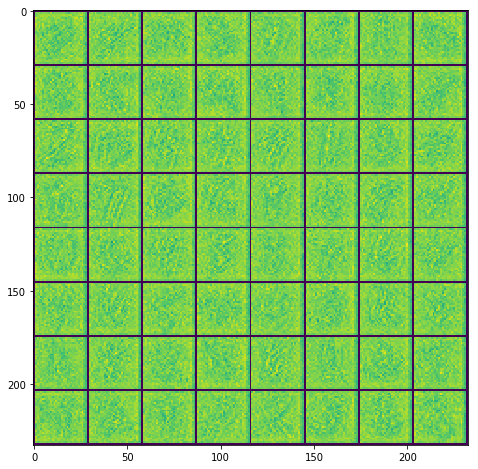

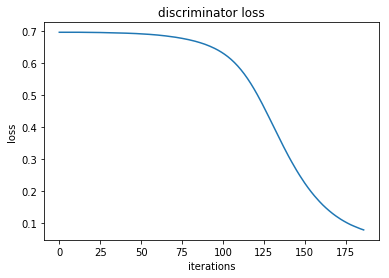

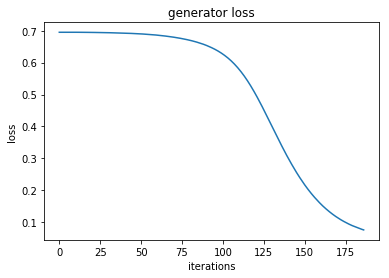

Iteration 200: dis loss = 0.0450, gen loss = 0.0440
Iteration 250: dis loss = 0.0412, gen loss = 0.0399
Iteration 300: dis loss = 0.0431, gen loss = 0.0419
Iteration 350: dis loss = 0.0414, gen loss = 0.0393
(64, 28, 28, 1)


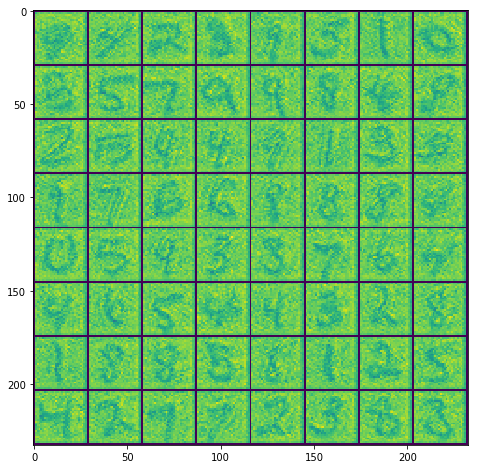

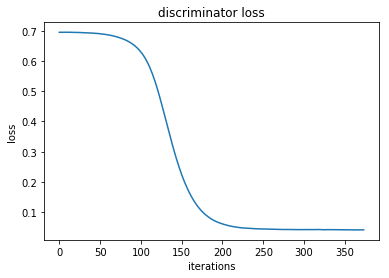

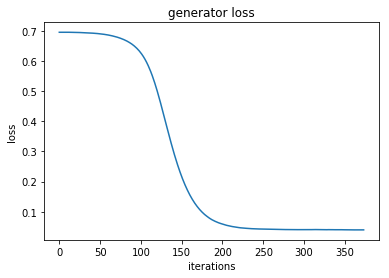

Iteration 400: dis loss = 0.0429, gen loss = 0.0420
Iteration 450: dis loss = 0.0426, gen loss = 0.0413
Iteration 500: dis loss = 0.0420, gen loss = 0.0405
Iteration 550: dis loss = 0.0393, gen loss = 0.0386
(64, 28, 28, 1)


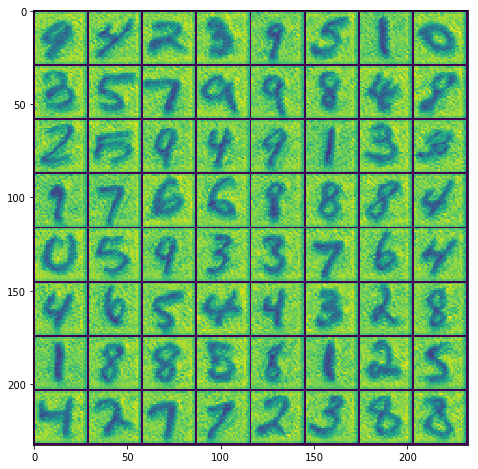

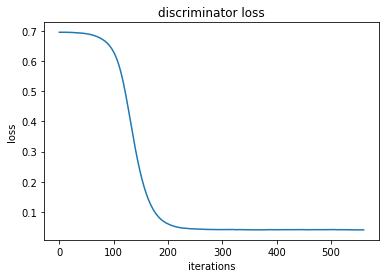

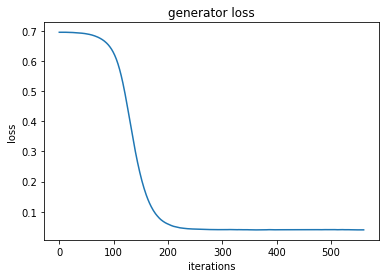

Iteration 600: dis loss = 0.0430, gen loss = 0.0416
Iteration 650: dis loss = 0.0390, gen loss = 0.0377
Iteration 700: dis loss = 0.0432, gen loss = 0.0419


KeyboardInterrupt: 

In [85]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)


class DCGAN(object):

    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 256
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_sentences = tf.placeholder(tf.float32, [None, 4800])
        self.real_images = tf.placeholder(tf.float32, [None, 28,28,1])
        
        self.real_labels = tf.placeholder(tf.float32, [None, 100])
        
        #self.fake_label = tf.placeholder(tf.float32, [None, 100])
        self.noise = tf.placeholder(tf.float32, [None, 256])
        
        self.is_train = tf.placeholder(tf.bool)
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            
            dis_conv1 = conv2d(input, 7, 1, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_maxpool1 = max_pool(dis_lrelu1,3,2 )
            
            dis_conv2 = conv2d(dis_maxpool1, 5, 1, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_maxpool2 = max_pool(dis_lrelu2,3,2)     
            
            dis_conv3 = conv2d(dis_maxpool2, 5, 1, 32, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_mazpool3 = max_pool(dis_lrelu3,3,2) 
            
            dis_reshape3 = tf.reshape(dis_mazpool3, [-1, 4 * 4 * 32])
            dis_fc4 = fc(dis_reshape3, 256, 'fc4')
            dis_lrelu3 = leaky_relu(dis_fc4)
            dis_fc5 = fc(dis_lrelu3, 100, 'fc5')
            
            return dis_fc5

    def _generator(self, noise,text_embedding, image_input):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_fc1 = fc(text_embedding, 256, 'fc1')
            gen_relu1 = leaky_relu(gen_fc1)
            z_text = tf.concat([noise, gen_relu1], 1)
            
            gen_fc2 = fc(z_text, 784*2, 'fc2')
            gen_relu2 = leaky_relu(gen_fc2)
            
            gen_reshape1 = tf.reshape(gen_relu2, [-1, 28, 28, 2])
            print gen_reshape1.shape
            image_reshape = tf.concat([image_input, gen_reshape1],3)
            print image_reshape.shape
            
            gen_batchnorm1 = batch_norm(image_reshape, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            print gen_lrelu1.shape
            gen_conv2 = conv2d(gen_lrelu1, 4, 1, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            print(gen_lrelu2.shape)
            gen_conv3 = conv2d(gen_lrelu2, 4, 1, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d(gen_lrelu3, 4, 1, 1, 'conv4')
            
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            print(gen_sigmoid4.shape)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        
        self.fake_samples_op = self._generator(self.noise, self.real_sentences,self.real_images)
        self.dis_loss_op = self._loss(self.real_labels,self._discriminator(self.fake_samples_op))
        self.gen_loss_op = self._loss(self.real_labels, self._discriminator(self.fake_samples_op))
        
        
        
        
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        first_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "dis")
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op,var_list = first_train_vars)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        second_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "gen")
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op, var_list = second_train_vars)

    # Training function
    def train(self, sess,train_images,train_sentences,train_labels ):
        sess.run(tf.global_variables_initializer())

        num_train = train_images.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        for epoch in range(self.num_epoch):
            for i in range(num_train // (10*self.batch_size)):
                step += 1

                image_batch = train_images[i * self.batch_size : (i + 1) * self.batch_size]
                sentence_batch = train_sentences[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, 256])
                labels = np.zeros([self.batch_size, 100])
                
                for j in range(self.batch_size ):
                    #if (j == 31):
                        #print(i*self.batch_size + j)
                    labels[j][train_labels[i*self.batch_size + j]] = 1

                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                dis_feed_dict = {self.real_images:image_batch, self.real_sentences:sentence_batch ,self.real_labels:labels, self.noise:noise,self.is_train:True}
        
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                gen_feed_dict = {self.noise:noise,self.real_images:image_batch, self.real_sentences:sentence_batch, self.real_labels:labels,self.is_train:True}
        
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(step, dis_loss, gen_loss))

            #fig = plt.figure(figsize = (8, 8))   
            #ax1 = plt.subplot(111)
            #generated_image = self.generate(self.tracked_noise)
            #print(generated_image.shape)
            #image = viz_grid(generated_image, 1)
            #print(image.shape)
            #image = image.reshape(30,30)
            #list = []
            #for i in range(3):
                #for j in range(image.shape[0]):
                    #list.append(image[j])
            #image = np.array(list)
            #image = image.reshape(30,30,3)
            
            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            gen = self.generate(self.tracked_noise)
            print (gen.shape)
            images = viz_grid(gen, 1)
            images = images.reshape(233,233)
            ax1.imshow(images,cmap='gray')
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()


    # Generates a single sample from input code
    def generate_one_sample(self, code, i):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
        image_batch = train_images[ i : i+1]
        sentence_batch = train_sentences[i : i+1]
        gen_vis_feed_dict = {self.noise:code,self.real_images:image_batch, self.real_sentences:sentence_batch, self.is_train:True}
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 28, 28, 1))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1],i)
        return generated



    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)
    
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        train_images = np.array(train_images)
        train_sentences = np.array(train_sentences)
        train_labels = np.array(train_labels)
        train_images = np.array(train_images)
        dcgan.train(sess, train_images,train_sentences,train_labels)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')



In [60]:
image = np.ndarray(shape=(5,5,1), dtype=float, order='F')
image = image.flatten()
print (image.shape)
list = []

for i in range(3):
    for j in range(image.shape[0]):
        list.append(image[j])
        
image = np.array(list)
image = image.reshape(5,5,3)

print image.shape

(25,)
(5, 5, 3)


In [68]:
for i in range(64):
    print (train_labels[i])

16
24
0
25
16
4
49
28
8
24
49
24
1
36
36
81
0
64
25
30
81
0
4
4
64
16
15
0
25
64
9
4
4
4
25
1
36
30
35
12
0
49
18
64
0
81
8
21
32
0
54
36
25
16
4
8
54
36
36
2
30
1
16
16
